In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [2]:
P_LAYERS = 4
SHOTS = 8000
SEED = 7
rng = np.random.default_rng(SEED)

In [3]:
data = np.load("portfolio_qubo_data.npz")
Q = data['Q']
q = data['q']
mu = data['mu']
Sigma = data['Sigma']
B = int(data['B'])
TICKERS = list(data['TICKERS'])
n = len(TICKERS)

print("Data loaded successfully.")
print(f"n = {n} (assets)")
print(f"B = {B} (cardinality)")
print(f"P_LAYERS = {P_LAYERS}")
print(f"Q shape: {Q.shape}")
print(f"q shape: {q.shape}")

Data loaded successfully.
n = 21 (assets)
B = 4 (cardinality)
P_LAYERS = 4
Q shape: (21, 21)
q shape: (21,)


In [4]:
def qubo_to_ising(Q, q):
    J = np.zeros((n, n))
    h = np.zeros(n)
    const = 0.0
    for i in range(n):
        for j in range(i+1, n):
            Jij = Q[i, j] / 4.0
            J[i, j] = Jij
            h[i] += -Q[i, j] / 4.0
            h[j] += -Q[i, j] / 4.0
            const += Q[i, j] / 4.0
    for i in range(n):
        h[i] += -(Q[i, i] / 2.0) - (q[i] / 2.0)
        const += (Q[i, i] / 2.0) + (q[i] / 2.0)
    return J, h, const

J, h, const_shift = qubo_to_ising(Q, q)
init_idx = rng.choice(n, size=B, replace=False)
init_bits = np.zeros(n, dtype=int)
init_bits[init_idx] = 1
print(f"\nInitial random state (indices): {init_idx}")


Initial random state (indices): [17 11 18 13]


In [5]:
def build_qaoa_xy(n, P, J, h, init_bits):
    qc = QuantumCircuit(n, name="QAOA_XY")
    for i, b in enumerate(init_bits):
        if b == 1:
            qc.x(i)
    gammas = [Parameter(f"γ_{k}") for k in range(P)]
    betas  = [Parameter(f"β_{k}") for k in range(P)]
    ring_pairs = [(i, (i+1) % n) for i in range(n)]
    for k in range(P):
        γ = gammas[k]
        β = betas[k]
        for i in range(n):
            if abs(h[i]) > 1e-15:
                qc.rz(2.0 * γ * h[i], i)
        for i in range(n):
            for j in range(i+1, n):
                if abs(J[i, j]) > 1e-15:
                    qc.append(RZZGate(2.0 * γ * J[i, j]), [i, j])
        for (i, j) in ring_pairs:
            qc.append(RXXGate(2.0 * β), [i, j])
            qc.append(RYYGate(2.0 * β), [i, j])
    return qc, gammas + betas

ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)

def f_qubo(x):
    return float(x @ Q @ x + q @ x)

def bitstr_from_int(k, n):
    return np.array(list(np.binary_repr(k, width=n)), dtype=int)

def bitarray_from_qiskit_string(s):
    return np.array(list(s[::-1]), dtype=int)

def bind_params(circ, mapping):
    return circ.assign_parameters(mapping, inplace=False)

def random_theta():
    return np.concatenate([
        rng.uniform(0.0, 2.0*np.pi, size=P_LAYERS),
        rng.uniform(0.0, 2.0*np.pi, size=P_LAYERS),
    ])

In [6]:
print("\nSetting up GPU backend")
gpu_backend = AerSimulator(device='GPU', method='automatic')
print(f"Using GPU backend: {gpu_backend.name}")

ansatz_meas = ansatz.copy()
ansatz_meas.measure_all()
t_ansatz = transpile(ansatz_meas, gpu_backend, optimization_level=1, seed_transpiler=SEED)
print(f"Pre-transpiled ansatz for backend.")

qaoa_trace = []

def objective_from_shots(theta):
    bind = {p: float(t) for p, t in zip(theta_params, theta)}
    bound_circ = bind_params(t_ansatz, bind)
    res = gpu_backend.run(bound_circ, shots=SHOTS, seed_simulator=SEED).result()
    counts = res.get_counts()
    exp_val = 0.0
    total_valid_shots = 0
    for s, c in counts.items():
        x = bitarray_from_qiskit_string(s)
        if x.sum() == B: 
            exp_val += c * f_qubo(x)
            total_valid_shots += c
    if total_valid_shots == 0:
        return 0.0 if not qaoa_trace else qaoa_trace[-1] 
    avg_cost = exp_val / total_valid_shots
    qaoa_trace.append(avg_cost)
    return avg_cost


Setting up GPU backend
Using GPU backend: aer_simulator
Pre-transpiled ansatz for backend.


In [7]:
print(f"\nStarting optimization (Scipy=True)")
t0_opt = time.perf_counter()
best_val, best_theta = np.inf, None

for i in range(30):
    print(f"  Starting multi-start {i+1}/30")
    x0 = random_theta()
    res = minimize(objective_from_shots, x0, method="COBYLA", options={"maxiter": 250, "rhobeg": 0.5})
    if res.fun < best_val:
        best_val, best_theta = res.fun, res.x
        print(f"    New best value: {best_val:.6f}")
        
t1_opt = time.perf_counter()
print(f"Optimization finished in {(t1_opt - t0_opt):.2f}s")


Starting optimization (Scipy=True)
  Starting multi-start 1/30
    New best value: -0.000828
  Starting multi-start 2/30
  Starting multi-start 3/30
    New best value: -0.000829
  Starting multi-start 4/30
  Starting multi-start 5/30
  Starting multi-start 6/30
  Starting multi-start 7/30
    New best value: -0.000829
  Starting multi-start 8/30
  Starting multi-start 9/30
  Starting multi-start 10/30
  Starting multi-start 11/30
  Starting multi-start 12/30
  Starting multi-start 13/30
  Starting multi-start 14/30
  Starting multi-start 15/30
  Starting multi-start 16/30
  Starting multi-start 17/30
  Starting multi-start 18/30
  Starting multi-start 19/30
  Starting multi-start 20/30
    New best value: -0.000829
  Starting multi-start 21/30
  Starting multi-start 22/30
  Starting multi-start 23/30
  Starting multi-start 24/30
  Starting multi-start 25/30
  Starting multi-start 26/30
  Starting multi-start 27/30
  Starting multi-start 28/30
  Starting multi-start 29/30
  Starting m

In [8]:
print(f"\n[QAOA] Best estimated expectation: {best_val:.6f}")
print(f"[QAOA] θ* = {best_theta}")
final_bound_circ = bind_params(t_ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)})
print("Running final sampling on backend")

t0_samp = time.perf_counter()
res = gpu_backend.run(final_bound_circ, shots=SHOTS, seed_simulator=SEED).result()
t1_samp = time.perf_counter()
print(f"Sampling finished in {(t1_samp - t0_samp):.2f}s")

counts = res.get_counts()
cands = []
for s, c in counts.items():
    x = bitarray_from_qiskit_string(s)
    if x.sum() == B:
        cands.append((s, c, f_qubo(x)))
if not cands:
    raise RuntimeError("No bitstrings with cardinality B were observed.")
    
s_best, c_best, fx_best = min(cands, key=lambda t: t[2])
x_best = bitarray_from_qiskit_string(s_best)
sel_idx = np.where(x_best == 1)[0]
sel_tickers = [TICKERS[i] for i in sel_idx]

print("\n[QAOA-XY Result]")
print(f"Bitstring (little-endian): {s_best}  (freq {c_best}/{SHOTS})")
print(f"Selected ({len(sel_idx)} = B): {sel_tickers}")
print(f"f(x*) = {fx_best:.6f} (Best cost *sampled*)")

w = np.zeros(n)
w[sel_idx] = 1.0 / B
mu_day = float(mu @ w)
var_day = float(w @ Sigma @ w)
mu_ann = 252 * mu_day
std_ann = np.sqrt(252 * var_day)
sharpe_qaoa = mu_ann / std_ann if std_ann > 1e-6 else 0.0

print("\n[Approx. Metrics]")
print(f"Expected annual return ≈ {mu_ann:.2%}")
print(f"Annual volatility ≈ {std_ann:.2%}")
print(f"Sharpe Ratio ≈ {sharpe_qaoa:.3f}")
print("\nScript finished.")


[QAOA] Best estimated expectation: -0.000829
[QAOA] θ* = [2.08896621 3.10222419 1.742095   0.85131072 1.57287947 5.50067544
 5.49617783 0.78935627]
Running final sampling on backend
Sampling finished in 0.07s

[QAOA-XY Result]
Bitstring (little-endian): 000001100011000000000  (freq 1/8000)
Selected (4 = B): [np.str_('WMT'), np.str_('JNJ'), np.str_('TMO'), np.str_('JPM')]
f(x*) = -0.000915 (Best cost *sampled*)

[Approx. Metrics]
Expected annual return ≈ 40.58%
Annual volatility ≈ 18.71%
Sharpe Ratio ≈ 2.168

Script finished.


In [9]:
np.savez(
    "qaoa_results.npz",
    fx_qaoa=np.array(fx_best),
    mu_ann_qaoa=np.array(mu_ann),
    std_ann_qaoa=np.array(std_ann),
    sharpe_qaoa=np.array(sharpe_qaoa),
    x_qaoa=x_best
)


[Samples Summary] 3 valid bitstrings (|x|=4) observed.


,bitstring_qiskit_le,shots,prob,cost,indices,tickers
0,000001100010100000000,7997,0.999625,-0.000829,"[8, 10, 14, 15]","BRK-B, JNJ, TMO, JPM"
1,000001010010100000000,2,0.000250,-0.000897,"[8, 10, 13, 15]","BRK-B, JNJ, ABBV, JPM"
2,000001100011000000000,1,0.000125,-0.000915,"[9, 10, 14, 15]","WMT, JNJ, TMO, JPM"


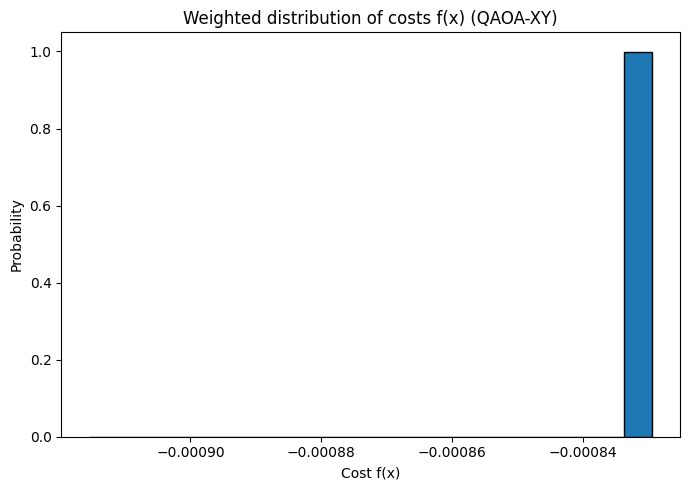

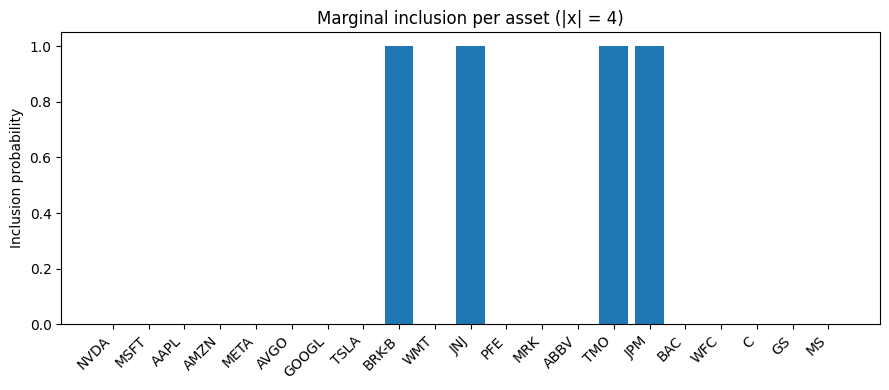

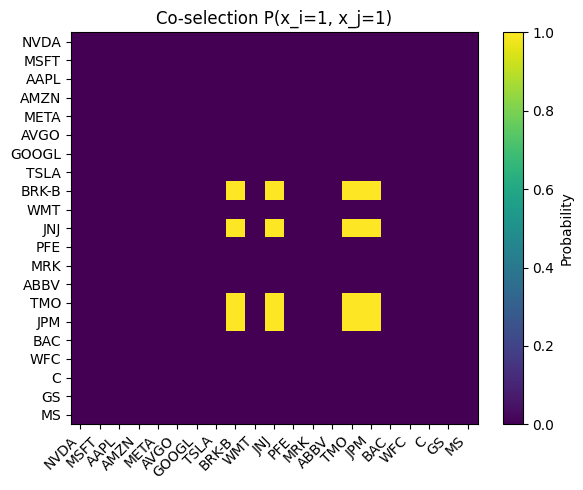

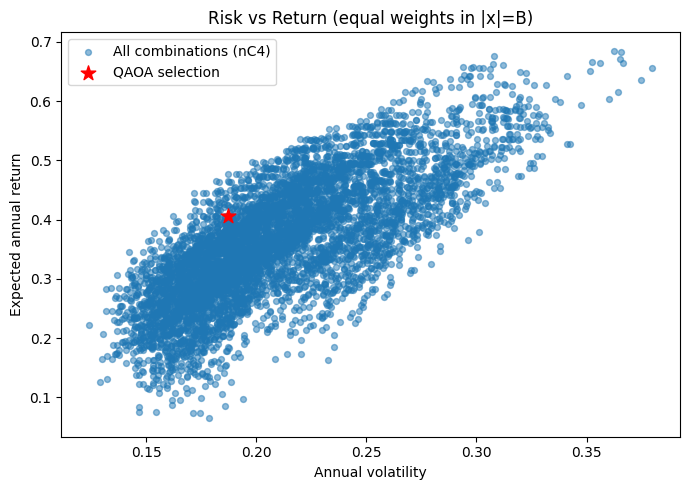

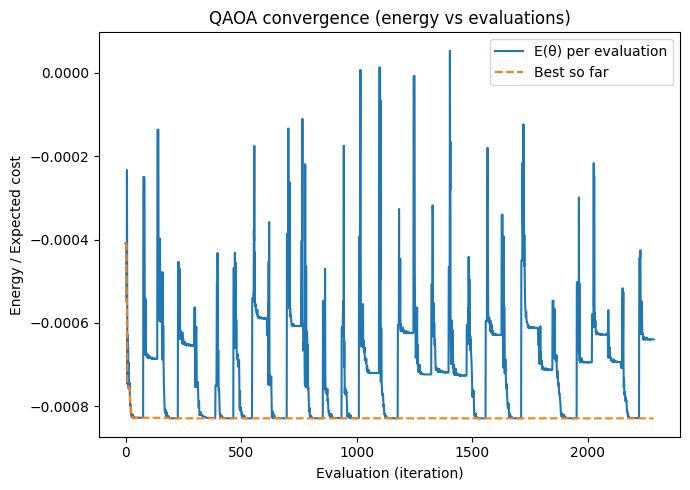


[Circuit complexity]
Qubits: 21, Layers p: 4, Parameters: 8
Pre-transpile -> depth: 256, size: 1096, ops: {'rzz': 840, 'rz': 84, 'rxx': 84, 'ryy': 84, 'x': 4}
Post-transpile -> depth: 254, size: 1077, ops: {'rzz': 805, 'rxx': 84, 'ryy': 84, 'rz': 79, 'measure': 21, 'u3': 4, 'barrier': 1}
Times -> Optimization: 187.30s | Sampling: 0.07s


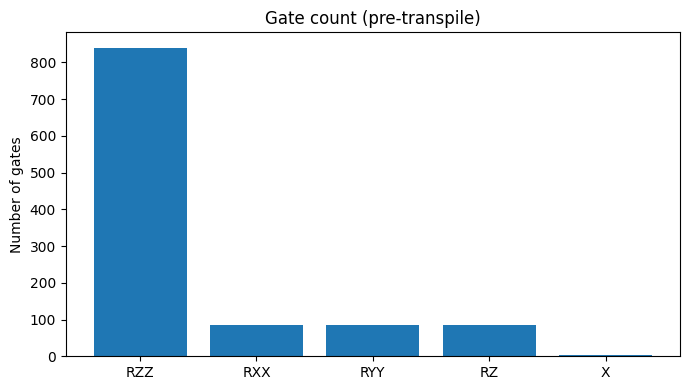


[Distribution of results |x|=B] Entropy: 0.0036 nats | Effective sample size: 1.0


In [10]:
#%% VISUALIZATION BLOCK
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import combinations

# --- Build DataFrame of samples (only |x| = B) ---
rows = []
total_shots = sum(counts.values())
for s, c in counts.items():
    x = bitarray_from_qiskit_string(s)
    if x.sum() != B:
        continue
    prob = c / total_shots
    cost = f_qubo(x)
    idx = np.where(x == 1)[0]
    tickers = [TICKERS[i] for i in idx]
    rows.append({
        "bitstring_qiskit_le": s,
        "shots": c,
        "prob": prob,
        "cost": cost,
        "indices": idx,
        "tickers": ", ".join(tickers)
    })

samples_df = (
    pd.DataFrame(rows)
    .sort_values(["prob", "cost"], ascending=[False, True])
    .reset_index(drop=True)
)

print(f"\n[Samples Summary] {len(samples_df)} valid bitstrings (|x|={B}) observed.")
display(samples_df.head(10))

# --- 1) Histogram of costs weighted by probability ---
plt.figure(figsize=(7, 5))
plt.hist(samples_df["cost"], bins=20, weights=samples_df["prob"], edgecolor="black")
plt.xlabel("Cost f(x)")
plt.ylabel("Probability")
plt.title("Weighted distribution of costs f(x) (QAOA-XY)")
plt.tight_layout()
plt.show()

# --- 2) Marginal inclusion probability per asset ---
p_incl = np.zeros(n)
for _, r in samples_df.iterrows():
    idx = np.array(r["indices"], dtype=int).reshape(-1)
    x = np.zeros(n)
    x[idx] = 1
    p_incl += r["prob"] * x

plt.figure(figsize=(9, 4))
plt.bar(TICKERS, p_incl)
plt.ylabel("Inclusion probability")
plt.title(f"Marginal inclusion per asset (|x| = {B})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 3) Co-selection heatmap P(x_i=1, x_j=1) ---
P_ij = np.zeros((n, n))
for _, r in samples_df.iterrows():
    idx = np.array(r["indices"], dtype=int).reshape(-1)
    for i in idx:
        for j in idx:
            P_ij[i, j] += r["prob"]

plt.figure(figsize=(6, 5))
plt.imshow(P_ij, aspect="auto")
plt.xticks(range(n), TICKERS, rotation=45, ha="right")
plt.yticks(range(n), TICKERS)
plt.title("Co-selection P(x_i=1, x_j=1)")
plt.colorbar(label="Probability")
plt.tight_layout()
plt.show()

# --- 4) Risk-Return scatter: all C(n,B) vs QAOA selection ---
def metrics_for_indices(sel_idx):
    idx = np.array(sel_idx, dtype=int).reshape(-1)
    w = np.zeros(n)
    w[idx] = 1.0 / B
    mu_day = float(mu @ w)
    var_day = float(w @ Sigma @ w)
    mu_ann = 252 * mu_day
    std_ann = np.sqrt(252 * var_day)
    return mu_ann, std_ann

all_mu, all_std = [], []
for comb in combinations(range(n), B):
    m, s = metrics_for_indices(comb)
    all_mu.append(m)
    all_std.append(s)

qaoa_mu, qaoa_std = metrics_for_indices(sel_idx)

plt.figure(figsize=(7, 5))
plt.scatter(all_std, all_mu, s=18, alpha=0.5, label=f"All combinations (nC{B})")
plt.scatter([qaoa_std], [qaoa_mu], s=120, marker="*", color="red", label="QAOA selection", zorder=3)
plt.xlabel("Annual volatility")
plt.ylabel("Expected annual return")
plt.title("Risk vs Return (equal weights in |x|=B)")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) QAOA convergence trace ---
if len(qaoa_trace) > 0:
    y = np.array(qaoa_trace, dtype=float)
    best_so_far = np.minimum.accumulate(y)
    plt.figure(figsize=(7, 5))
    plt.plot(y, label="E(θ) per evaluation")
    plt.plot(best_so_far, linestyle="--", label="Best so far")
    plt.xlabel("Evaluation (iteration)")
    plt.ylabel("Energy / Expected cost")
    plt.title("QAOA convergence (energy vs evaluations)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No energy trace recorded.")

# --- 6) Circuit complexity analysis ---
bound_circ = bind_params(ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)})
pre_depth = bound_circ.depth()
pre_size  = bound_circ.size()
pre_ops   = bound_circ.count_ops()

tqc = transpile(bound_circ.measure_all(inplace=False) or bound_circ, gpu_backend)
post_depth = tqc.depth()
post_size  = tqc.size()
post_ops   = tqc.count_ops()

print("\n[Circuit complexity]")
print(f"Qubits: {n}, Layers p: {P_LAYERS}, Parameters: {2*P_LAYERS}")
print(f"Pre-transpile -> depth: {pre_depth}, size: {pre_size}, ops: {dict(pre_ops)}")
print(f"Post-transpile -> depth: {post_depth}, size: {post_size}, ops: {dict(post_ops)}")
print(f"Times -> Optimization: {(t1_opt - t0_opt):.2f}s | Sampling: {(t1_samp - t0_samp):.2f}s")

labels, vals = [], []
for k in ["rzz", "rxx", "ryy", "rz", "x"]:
    if k in pre_ops:
        labels.append(k.upper()); vals.append(int(pre_ops[k]))
if labels:
    plt.figure(figsize=(7, 4))
    plt.bar(labels, vals)
    plt.title("Gate count (pre-transpile)")
    plt.ylabel("Number of gates")
    plt.tight_layout()
    plt.show()

# --- 7) Distribution measures ---
probs = samples_df["prob"].values
eps = 1e-16
entropy = -np.sum(np.where(probs > 0, probs * np.log(probs + eps), 0.0))
ess = 1.0 / np.sum((probs + eps)**2)
print(f"\n[Distribution of results |x|=B] Entropy: {entropy:.4f} nats | Effective sample size: {ess:.1f}")